# Getting Started

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

## Solving ODEs

ODEs can be solved by `neurodiffeq.ode.solve`. 

Just for the sake of notation in the following examples, here we see differentiation as an operation, then an ODE can be rewritten as 

$$F(x, t) = 0.$$

### ODE Example 1: Exponential Decay

Start by solving 

$$\frac{dx}{dt} = -x.$$ 

for $x(t)$ with $x(0) = 1.0$. The analytical solution is 

$$
x = e^{-t}.
$$

For `neurodiffeq.ode.solve` to solve this ODE, the following parameters needs to be specified:

* `ode`: a function representing the ODE to be solved. It should be a function that maps $(x, t)$ to $F(x, t)$. Here we are solving $$F(x, t)=\dfrac{dx}{dt} + x=0,$$ then `ode` should be `lambda x, t: diff(x, t) - x`. `diff(x, t)` is the first order derivative of x with respect to t.

* `condition`: a `neurodiffeq.ode.Condition` instance representing the initial condition / boundary condition of the ODE. Here we use `IVP(t_0=0.0, x_0=1.0)` to ensure $x(0) = 1.0$.

* `t_min` and `t_max`: the domain of $t$ to solve the ODE on.

In [3]:
from neurodiffeq import diff      # the differentiation operation
from neurodiffeq.ode import solve # the ANN-based solver
from neurodiffeq.ode import IVP   # the initial condition

In [4]:
exponential = lambda x, t: diff(x, t) + x # specify the ODE
init_val_ex = IVP(t_0=0.0, x_0=1.0)       # specify the initial conditon

# solve the ODE
solution_ex, loss_ex = solve(
    ode=exponential, condition=init_val_ex, t_min=0.0, t_max=2.0
)

`solve` returns a tuple, where the first entry is the solution as a function and the second entry is the loss history. The solution is a function that maps $t$ to $x$. It accepts `numpy.array` as input as well. The default return type of the solution is `torch.tensor`. If we wanted to return `numpy.array`, we can specify `as_type='np'`. the loss history is a dictionary, where the 'train' entry is the training loss and the 'valid' entry is the validation loss. Here we compare the ANN-based solution with the analytical solution:

<IPython.core.display.Javascript object>


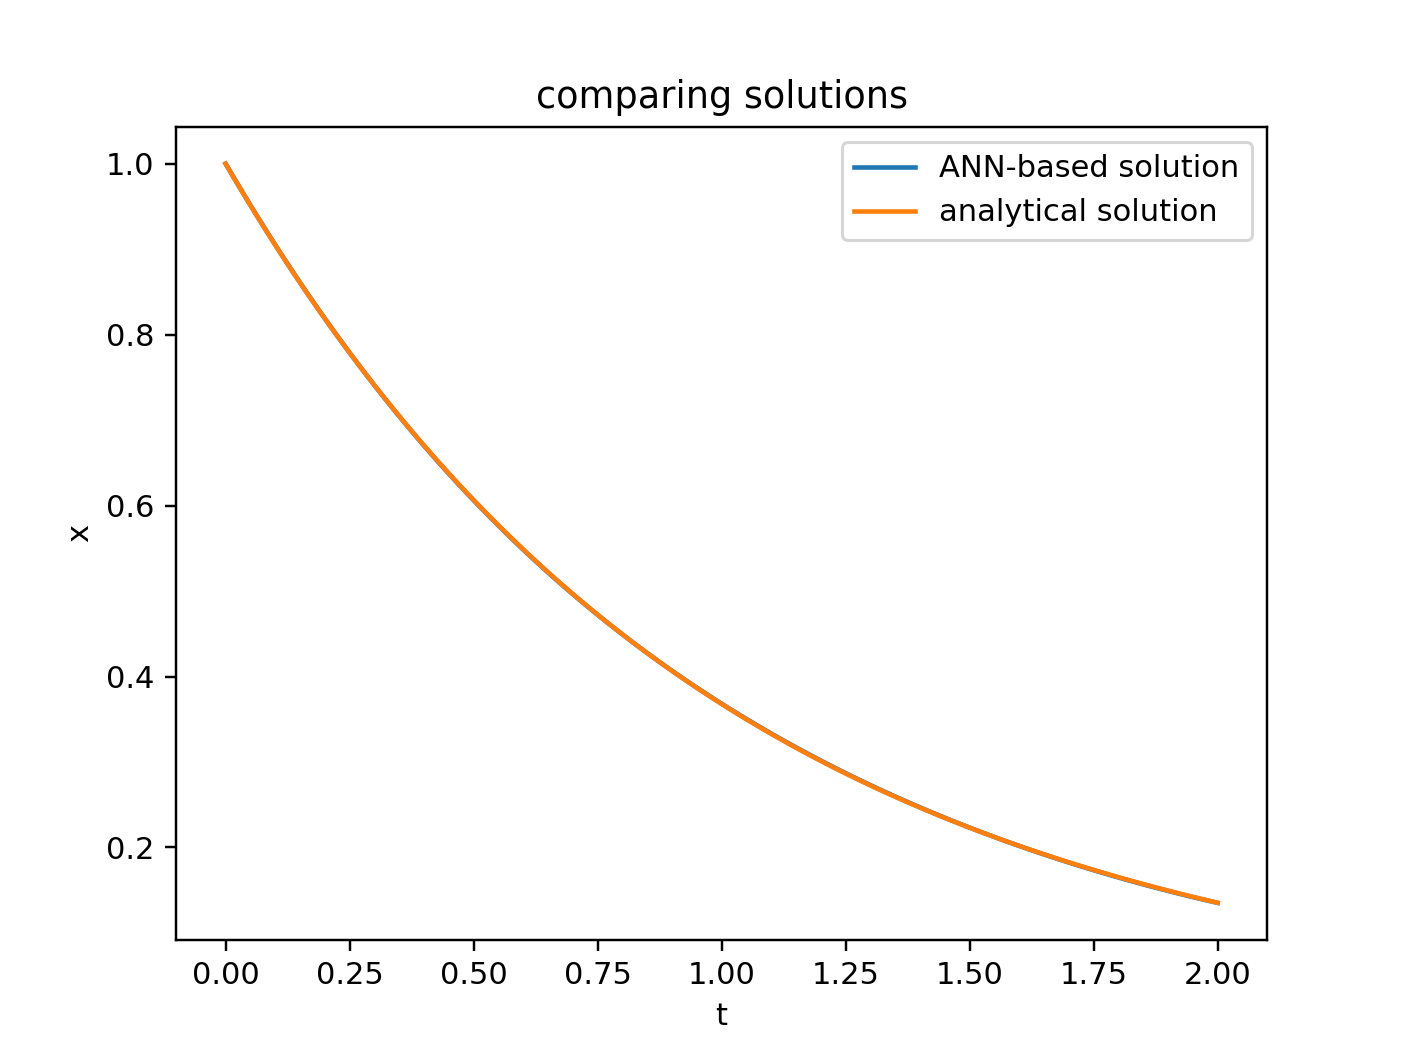

In [5]:
ts = np.linspace(0, 2.0, 100)
x_net = solution_ex(ts, as_type='np')
x_ana = np.exp(-ts)

plt.figure()
plt.plot(ts, x_net, label='ANN-based solution')
plt.plot(ts, x_ana, label='analytical solution')
plt.ylabel('x')
plt.xlabel('t')
plt.title('comparing solutions')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


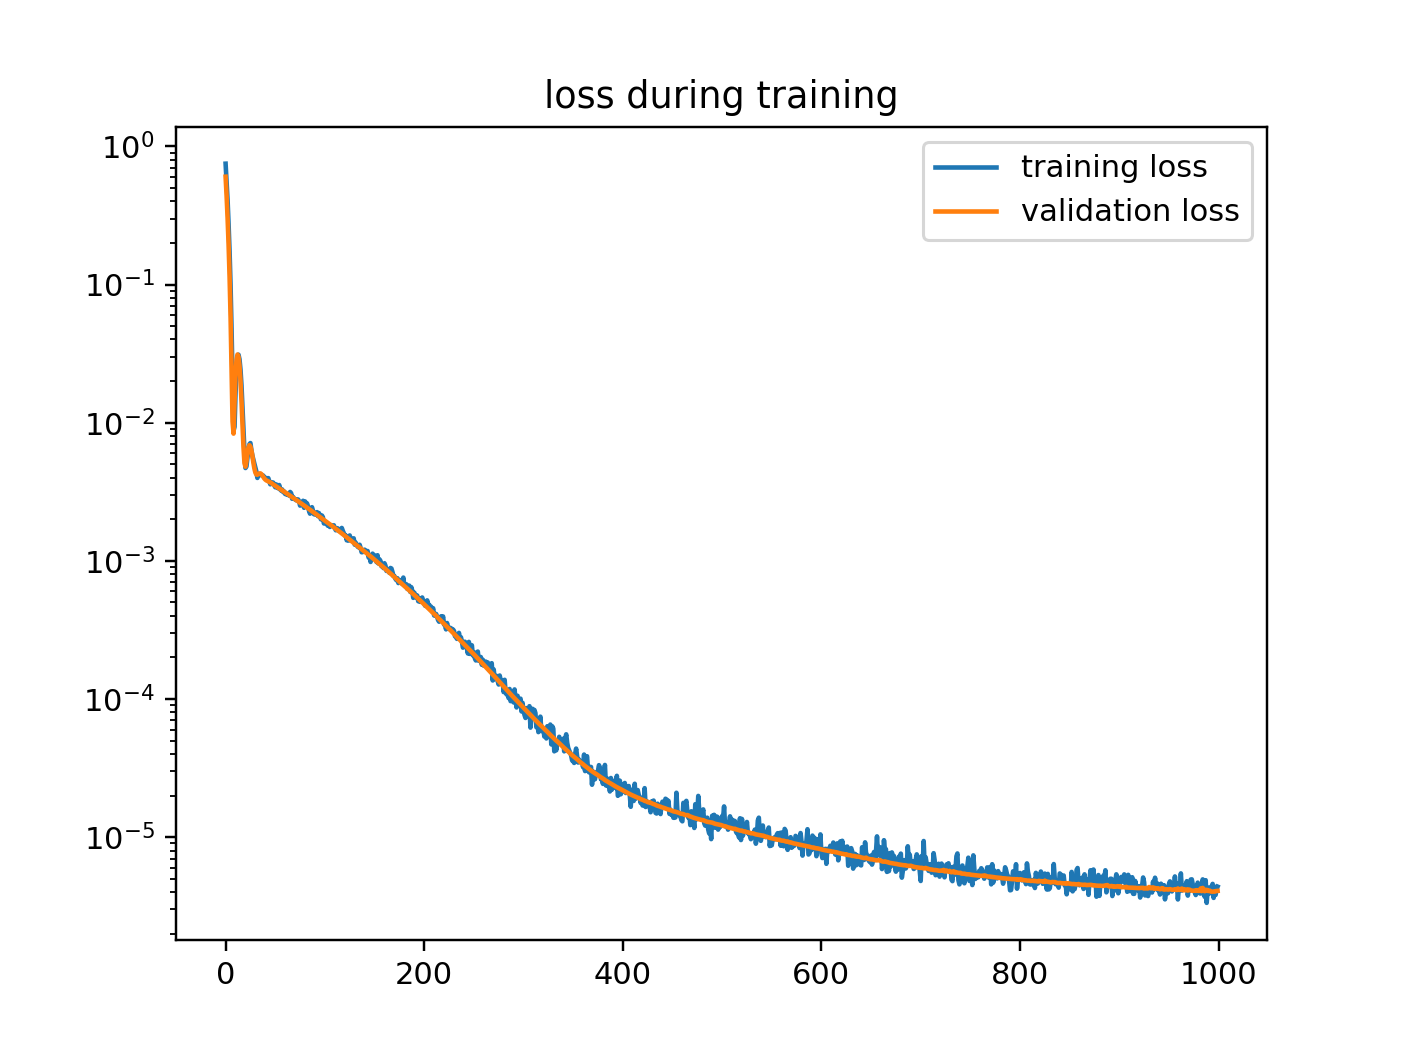

In [6]:
plt.figure()
plt.plot(loss_ex['train'], label='training loss')
plt.plot(loss_ex['valid'], label='validation loss')
plt.yscale('log')
plt.title('loss during training')
plt.legend()
plt.show()

We may want to see the check the solution and the loss function during solving the problem (training the network). To do this, we need to pass a `neurodiffeq.ode.Monitor` object to `solve`. A `Monitor` has the following parameters:

* `t_min` and `t_max`: the region of $t$ we want to monitor
* `check_every`: the frequency of visualization. If `check_every=100`, then the monitor will visualize the solution every 100 epochs.

`%matplotlib notebook` should be executed to allow `Monitor` to work. Here we solve the above ODE again.

In [7]:
from neurodiffeq.ode import Monitor

<IPython.core.display.Javascript object>


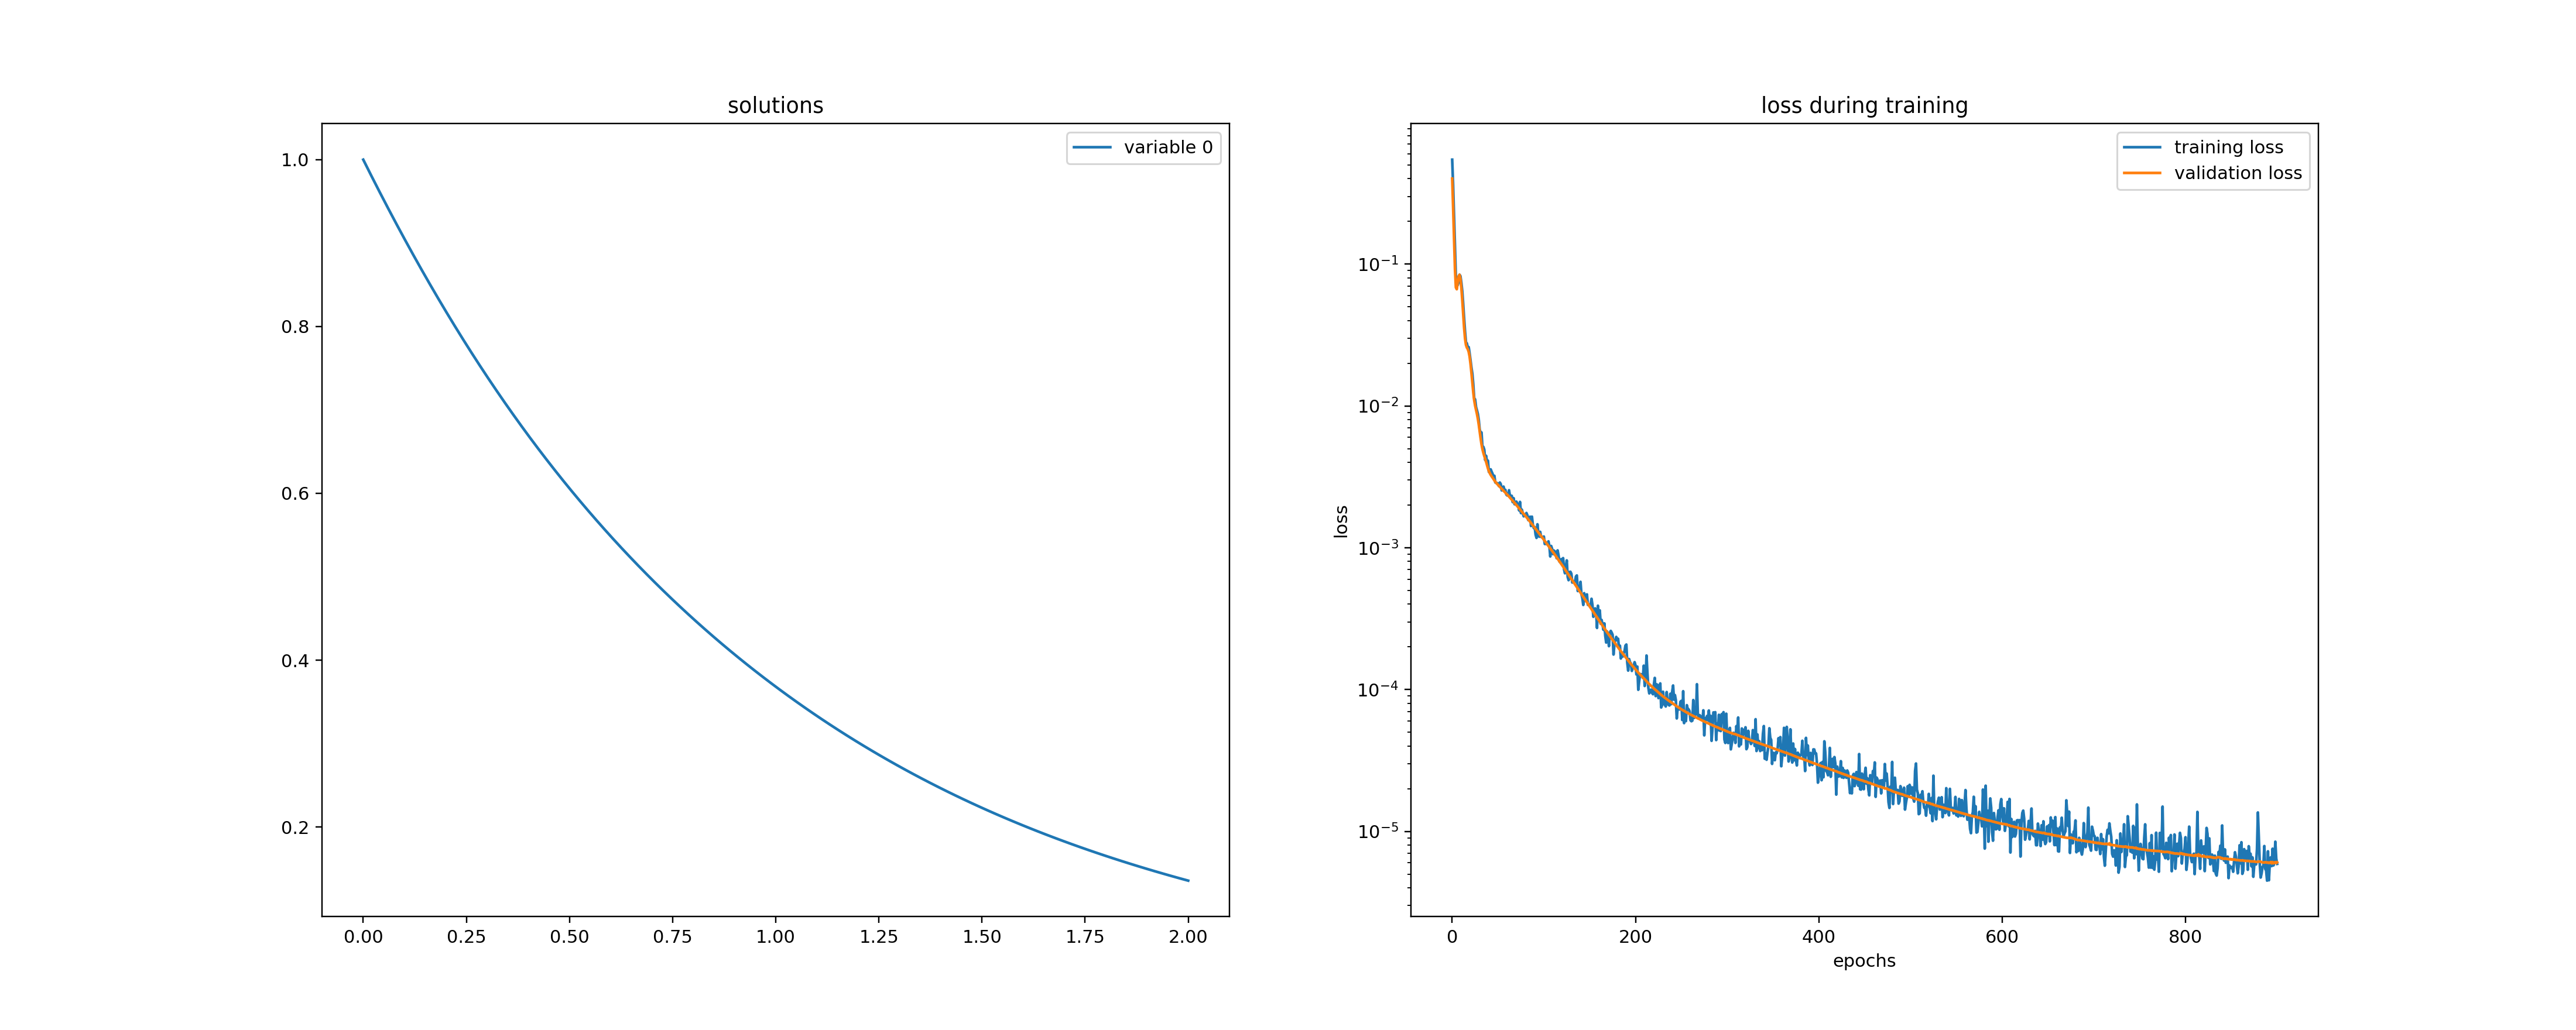

In [8]:
%matplotlib notebook
solution_ex, _ = solve(
    ode=exponential, condition=init_val_ex, t_min=0.0, t_max=2.0, 
    monitor=Monitor(t_min=0.0, t_max=2.0, check_every=100)
)

### ODE Example 2: Harmonic Oscilator

Here we solve a damped harmonic oscillator: 

$$
F(x, t) = \frac{d^2x}{dt^2} + x = 0
$$

for

$$
x(0) = 0.0, \frac{dx}{dt}|_{t=0} = 1.0
$$

The analytical solution is 

$$x = \sin(t)$$

We can include higher order derivatives in our ODE with the `order` keyword of `diff`, which is defaulted to 1.

Initial condition on $\dfrac{dx}{dt}$ can be specified with the `x_0_prime` keyword of `IVP`. 

Here we will use another keyword for `solve`:

* `max_epochs`: the number of epochs to run

<IPython.core.display.Javascript object>


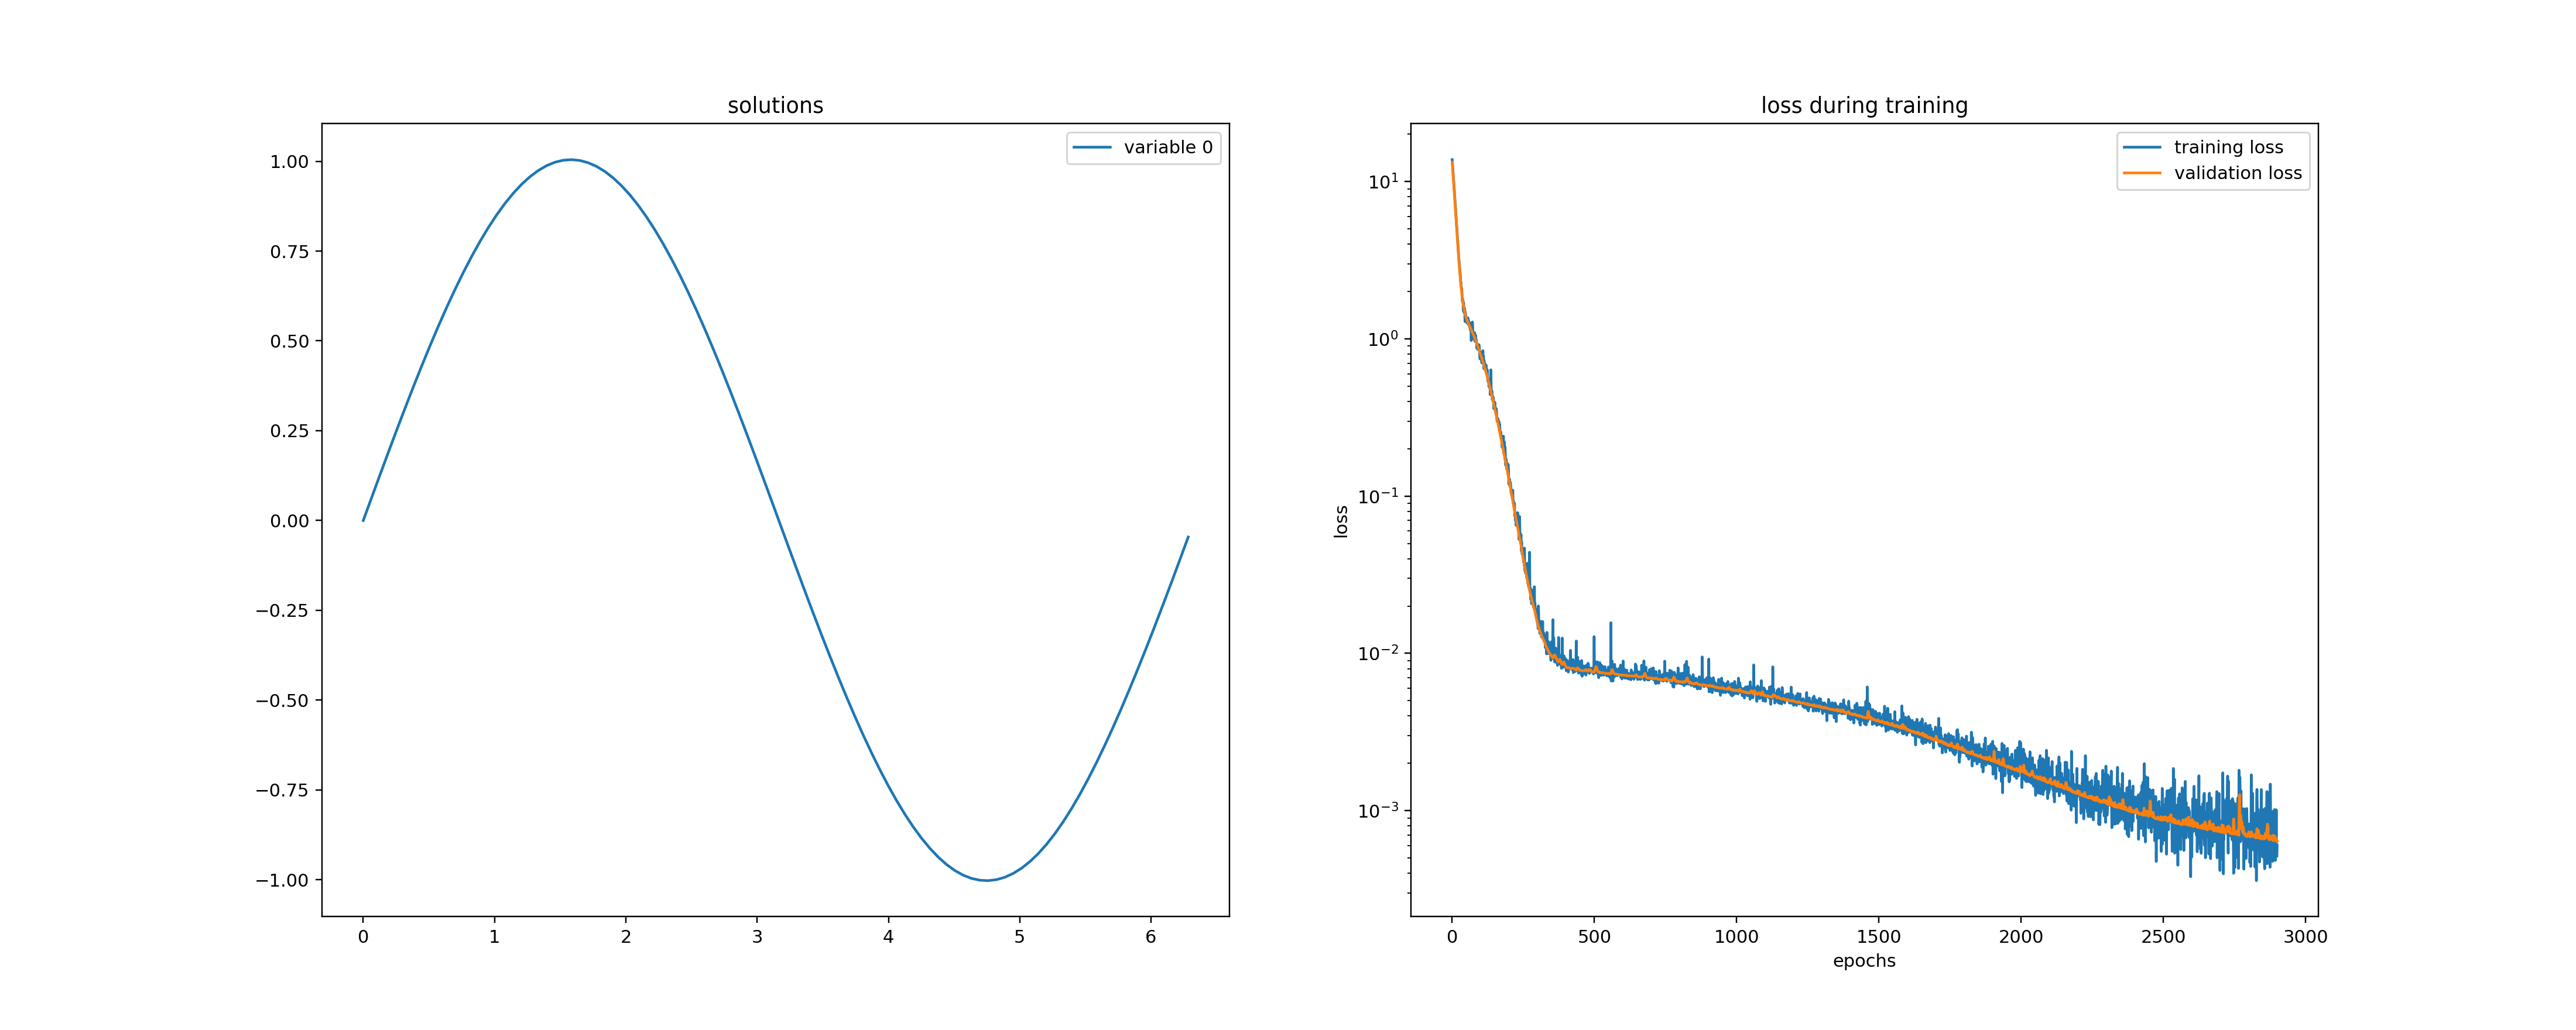

In [9]:
harmonic_oscillator = lambda x, t: diff(x, t, order=2) + x
init_val_ho = IVP(t_0=0.0, x_0=0.0, x_0_prime=1.0)

solution_ho, _ = solve(
    ode=harmonic_oscillator, condition=init_val_ho, t_min=0.0, t_max=2*np.pi, 
    max_epochs=3000,
    monitor=Monitor(t_min=0.0, t_max=2*np.pi, check_every=100)
)

<IPython.core.display.Javascript object>


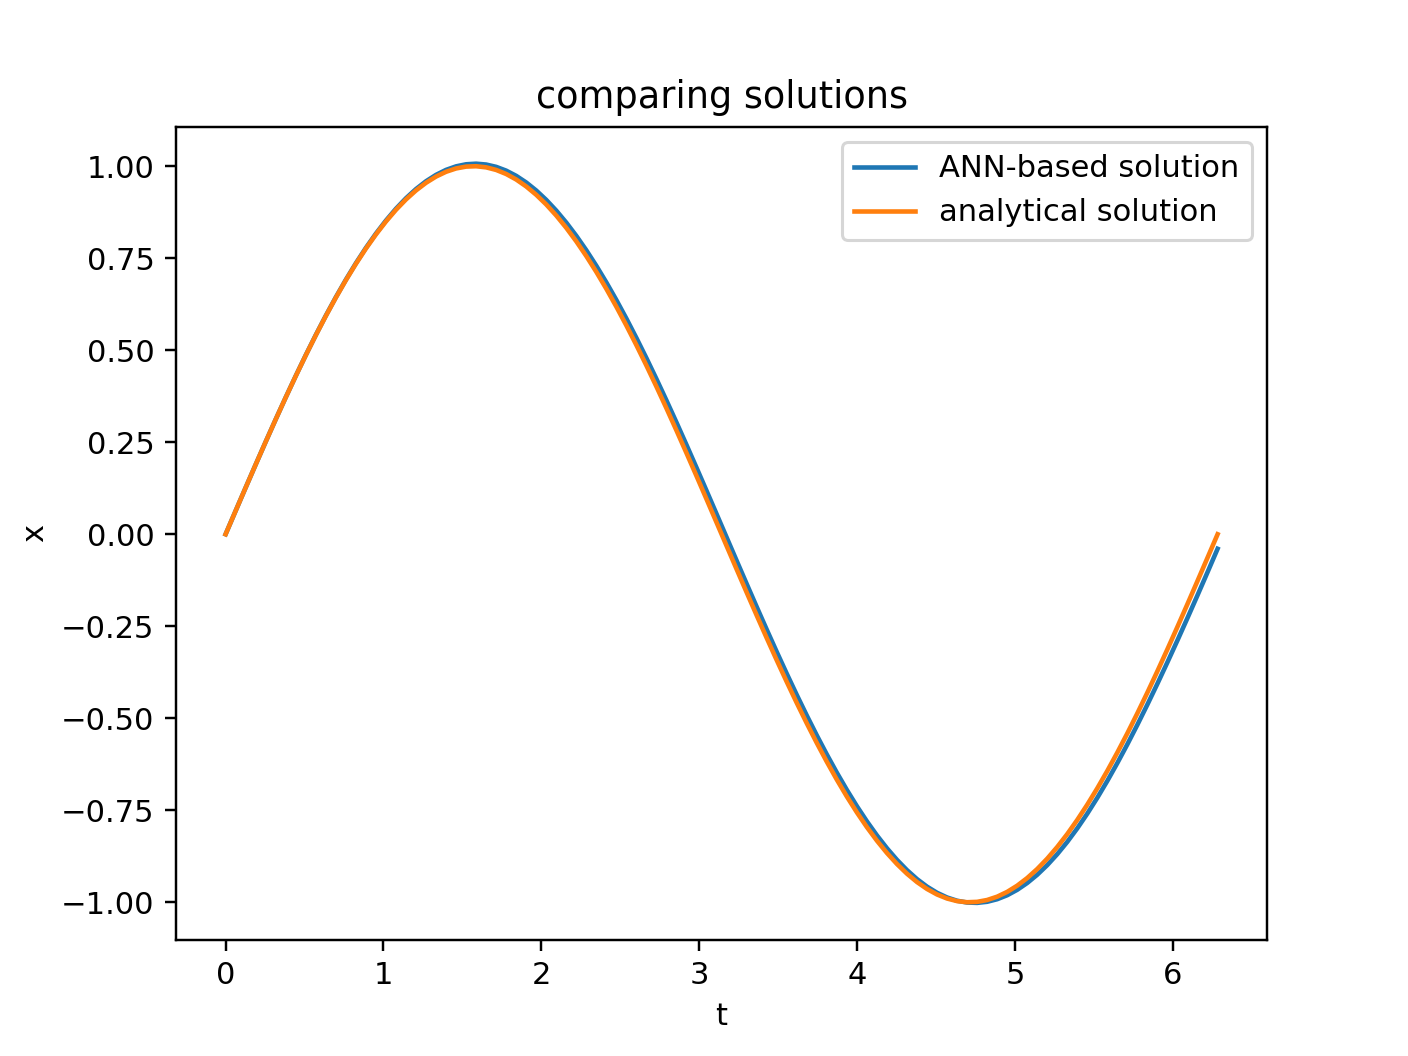

In [10]:
ts = np.linspace(0, 2*np.pi, 100)
x_net = solution_ho(ts, as_type='np')
x_ana = np.sin(ts)

plt.figure()
plt.plot(ts, x_net, label='ANN-based solution')
plt.plot(ts, x_ana, label='analytical solution')
plt.ylabel('x')
plt.xlabel('t')
plt.title('comparing solutions')
plt.legend()
plt.show()

## Solving Systems of ODEs

Systems of ODEs can be solved by `neurodiffeq.ode.solve_system`. 

Again, just for the sake of notation in the following examples, here we see differentiation as an operation, and see each element $x_i$of $\vec{x}$ as different dependent vairables, then a ODE system above can be rewritten as

$$
\begin{pmatrix} 
F_0(x_0, x_1, \ldots, x_{m-1}, t) \\
F_1(x_0, x_1, \ldots, x_{m-1}, t) \\
\vdots \\
F_{m-1}(x_0, x_1, \ldots, x_{m-1}, t)
\end{pmatrix}
= 
\begin{pmatrix} 
0 \\
0 \\
\vdots \\
0
\end{pmatrix}
$$

### Systems of ODE Example 1: Harmonic Oscilator

For the harmonic oscillator example above, if we let $x_1 = x$ and $x_2 = \dfrac{dx}{dt}$. We can rewrite this ODE into a system of ODE:

$$\begin{align}
x_1^{'} - x_2 &= 0, \\
x_2^{'} + x_1 &= 0, \\
x_1(0) &= 0, \\
x_2(0) &= 1.
\end{align}$$

Here the analytical solution is 
$$\begin{align}
x_1 &= \sin(t), \\
x_2 &= \cos(t).
\end{align}$$

The `solve_system` function is for solving ODE systems. The signature is almost the same as `solve` except that we specify an `ode_system` and a set of `conditions`. 

* `ode_system`: a function representing the system of ODEs to be solved. If the our system of ODEs is $f_i(x_0, x_1, ..., x_{m-1}, t) = 0$ for $i = 0, 1, ..., n-1$ where $x_0, x_1, ..., x_{m-1}$ are dependent variables and $t$ is the independent variable, then `ode_system` should map $(x_0, x_1, ..., x_{m-1}, t)$ to a $n$-element list where the $i^{th}$ element is the value of $f_i(x_0, x_1, ..., x_{m-1}, t)$.

* `conditions`: the initial value/boundary conditions as a list of Condition instance. They should be in an order such that the first condition constraints the first variable in $f_i$'s (see above) signature ($x_0$). The second condition constraints the second ($x_1$), and so on.

In [11]:
from neurodiffeq.ode import solve_system

<IPython.core.display.Javascript object>


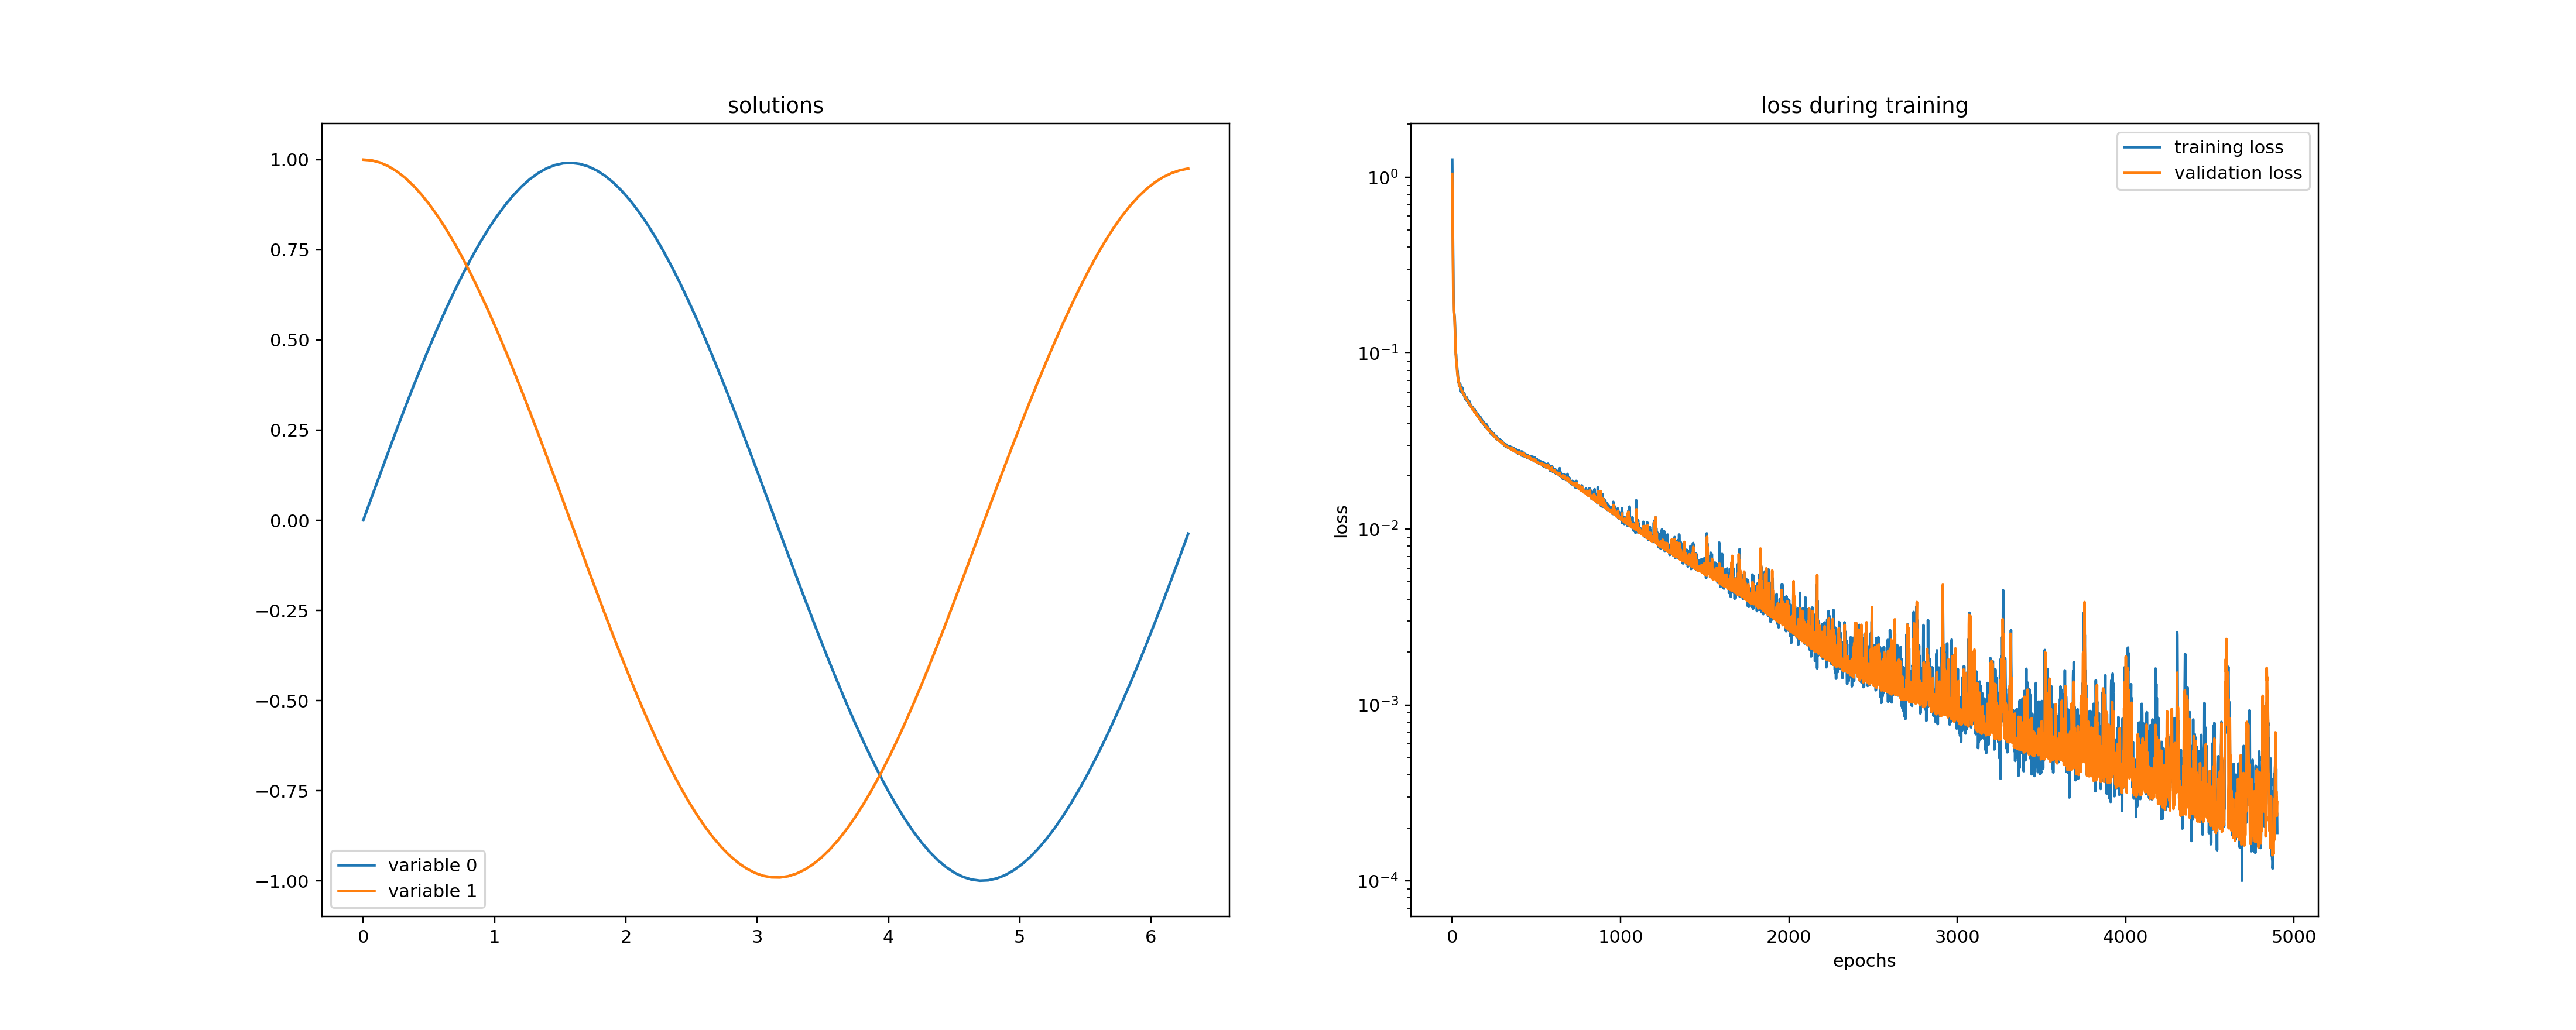

In [12]:
# specify the ODE system
parametric_circle = lambda x1, x2, t : [diff(x1, t) - x2, 
                                        diff(x2, t) + x1]
# specify the initial conditions
init_vals_pc = [
    IVP(t_0=0.0, x_0=0.0),
    IVP(t_0=0.0, x_0=1.0)
]

# solve the ODE system
solution_pc, _ = solve_system(
    ode_system=parametric_circle, conditions=init_vals_pc, t_min=0.0, t_max=2*np.pi, 
    max_epochs=5000,
    monitor=Monitor(t_min=0.0, t_max=2*np.pi, check_every=100)
)

`solve_system` returns a tuple, where the first entry is the solution as a function and the second entry is the loss history as a list. The solution is a function that maps $t$ to $[x_0, x_1, ..., x_{m-1}]$. It accepts `numpy.array` as input as well. Here we compare the ANN-based solution with the analytical solution:

<IPython.core.display.Javascript object>


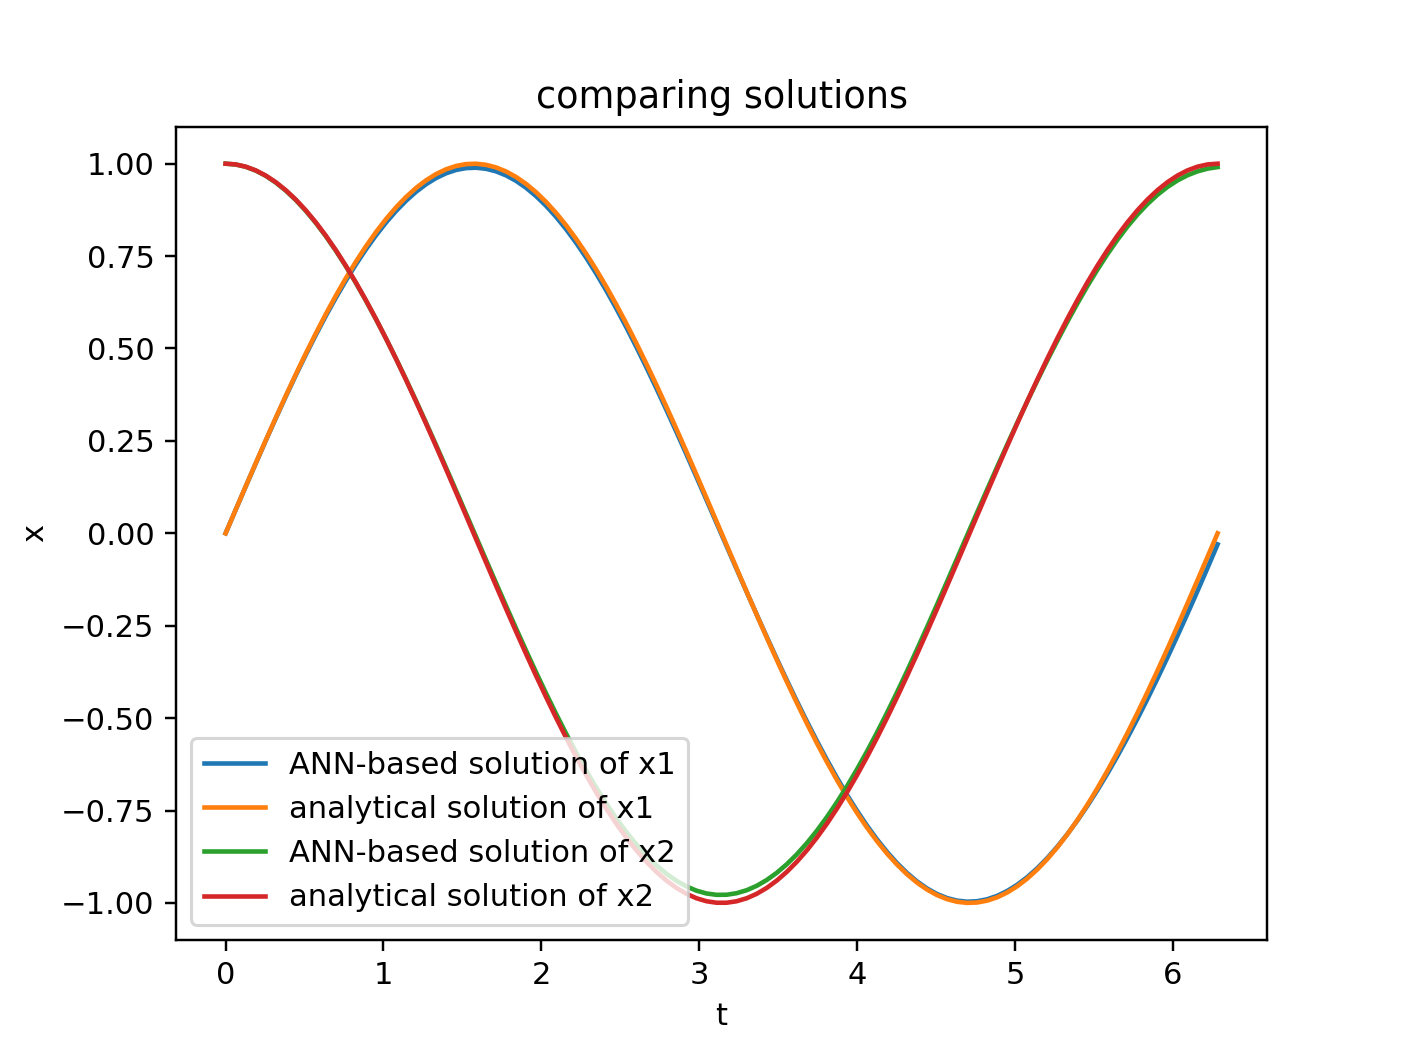

In [14]:
ts = np.linspace(0, 2*np.pi, 100)
x1_net, x2_net = solution_pc(ts, as_type='np')
x1_ana, x2_ana = np.sin(ts), np.cos(ts)

plt.figure()
plt.plot(ts, x1_net, label='ANN-based solution of x1')
plt.plot(ts, x1_ana, label='analytical solution of x1')
plt.plot(ts, x2_net, label='ANN-based solution of x2')
plt.plot(ts, x2_ana, label='analytical solution of x2')
plt.ylabel('x')
plt.xlabel('t')
plt.title('comparing solutions')
plt.legend()
plt.show()

### Systems of ODE Example 2: Lotka–Volterra equations

Lotka–Volterra equations are a pair of nonlinear ODE frequently used to describe the dynamics of biological systems in which two species interact, one as a predator and the other as prey:

$$\begin{align}
\frac{dx}{dt} = \alpha x - \beta xy \\
\frac{dy}{dt} = \delta xy - \gamma y
\end{align}$$

Let $\alpha = \beta = \delta = \gamma = 1$. Here we solve this pair of ODE when $x(0) = 1.5$ and $y(0) = 1.0$.

If not specified otherwise, `solve` and `solve_system` will use a fully-connected network with 1 hidden layer with 32 hidden units (tanh activation) to approximate each dependent variables. In some situations, we may want to use our own neural network. For example, the default neural net is not good at solving a problem where the solution oscillates. However, if we know in advance that the solution oscillates, we can use sin as activation function, which resulted in much faster convergence.

`neurodiffeq.FCNN` is a fully connected neural network. It is initiated by the following parameters:

* `n_hidden_units`: number of units for each hidden layer. Each hidden layer's number of units will be the same.

* `n_hidden_layers`: number of hidden layers

* `actv`: a `torch.nn.Module` *class*. e.g. `nn.Tanh`, `nn.Sigmoid`.

Here we will use another keyword for `solve_system`:

* `nets`: a list of networks to be used to approximate each dependent variable

In [15]:
from neurodiffeq.networks import FCNN    # fully-connect neural network
from neurodiffeq.networks import SinActv # sin activation

<IPython.core.display.Javascript object>


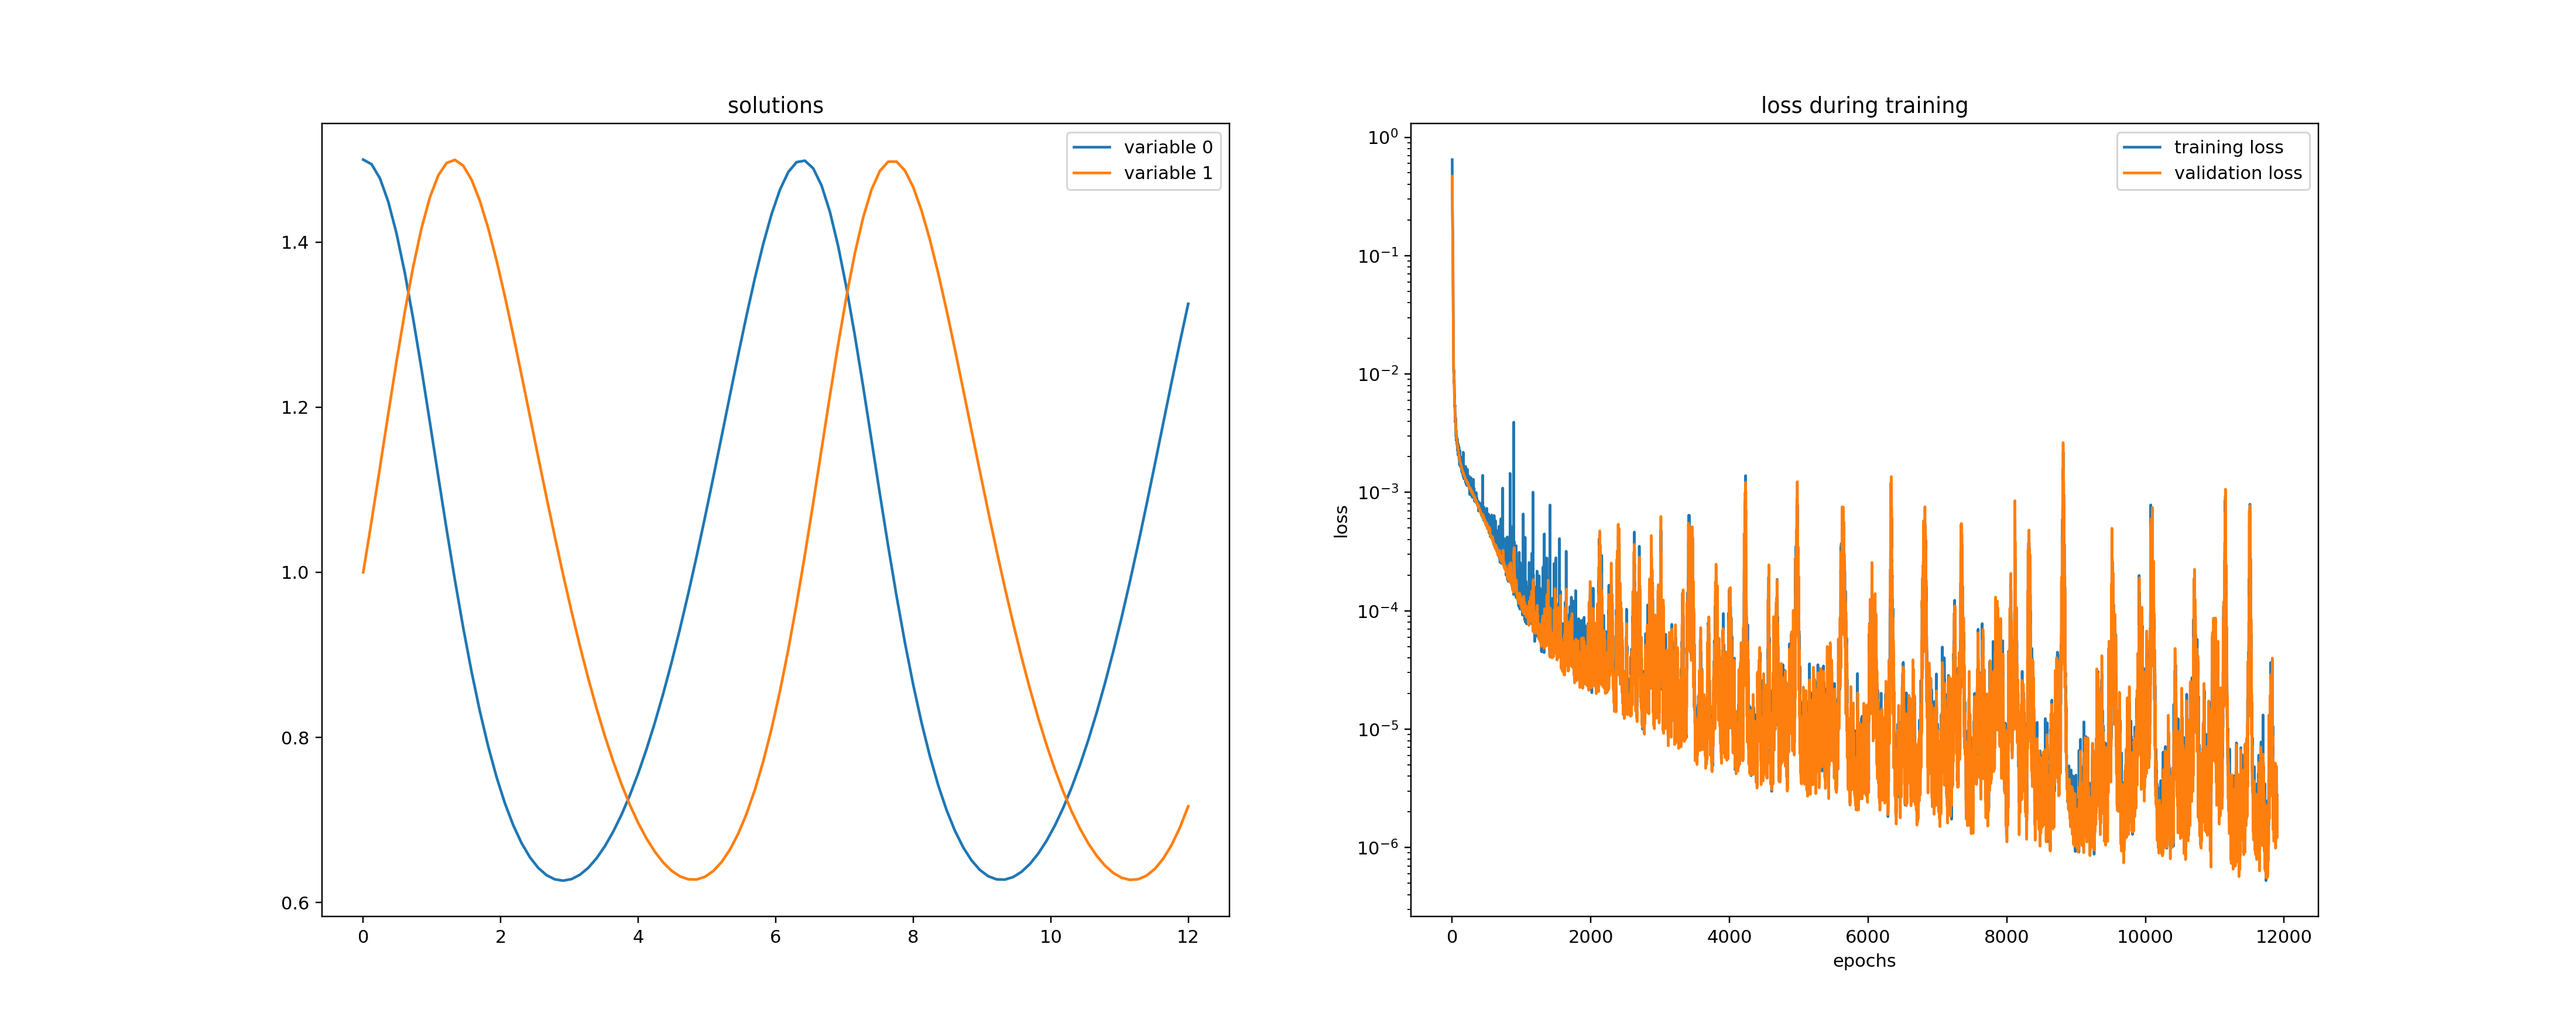

In [16]:
# specify the ODE system and its parameters
alpha, beta, delta, gamma = 1, 1, 1, 1
lotka_volterra = lambda x, y, t : [diff(x, t) - (alpha*x  - beta*x*y), 
                                   diff(y, t) - (delta*x*y - gamma*y)]
# specify the initial conditions
init_vals_lv = [
    IVP(t_0=0.0, x_0=1.5),
    IVP(t_0=0.0, x_0=1.0)
]

# specify the network to be used to approximate each dependent variable
nets_lv = [
    FCNN(n_hidden_units=32, n_hidden_layers=1, actv=SinActv),
    FCNN(n_hidden_units=32, n_hidden_layers=1, actv=SinActv)
]

# solve the ODE system
solution_lv, _ = solve_system(
    ode_system=lotka_volterra, conditions=init_vals_lv, t_min=0.0, t_max=12, 
    nets=nets_lv, max_epochs=12000,
    monitor=Monitor(t_min=0.0, t_max=12, check_every=100)
)

<IPython.core.display.Javascript object>


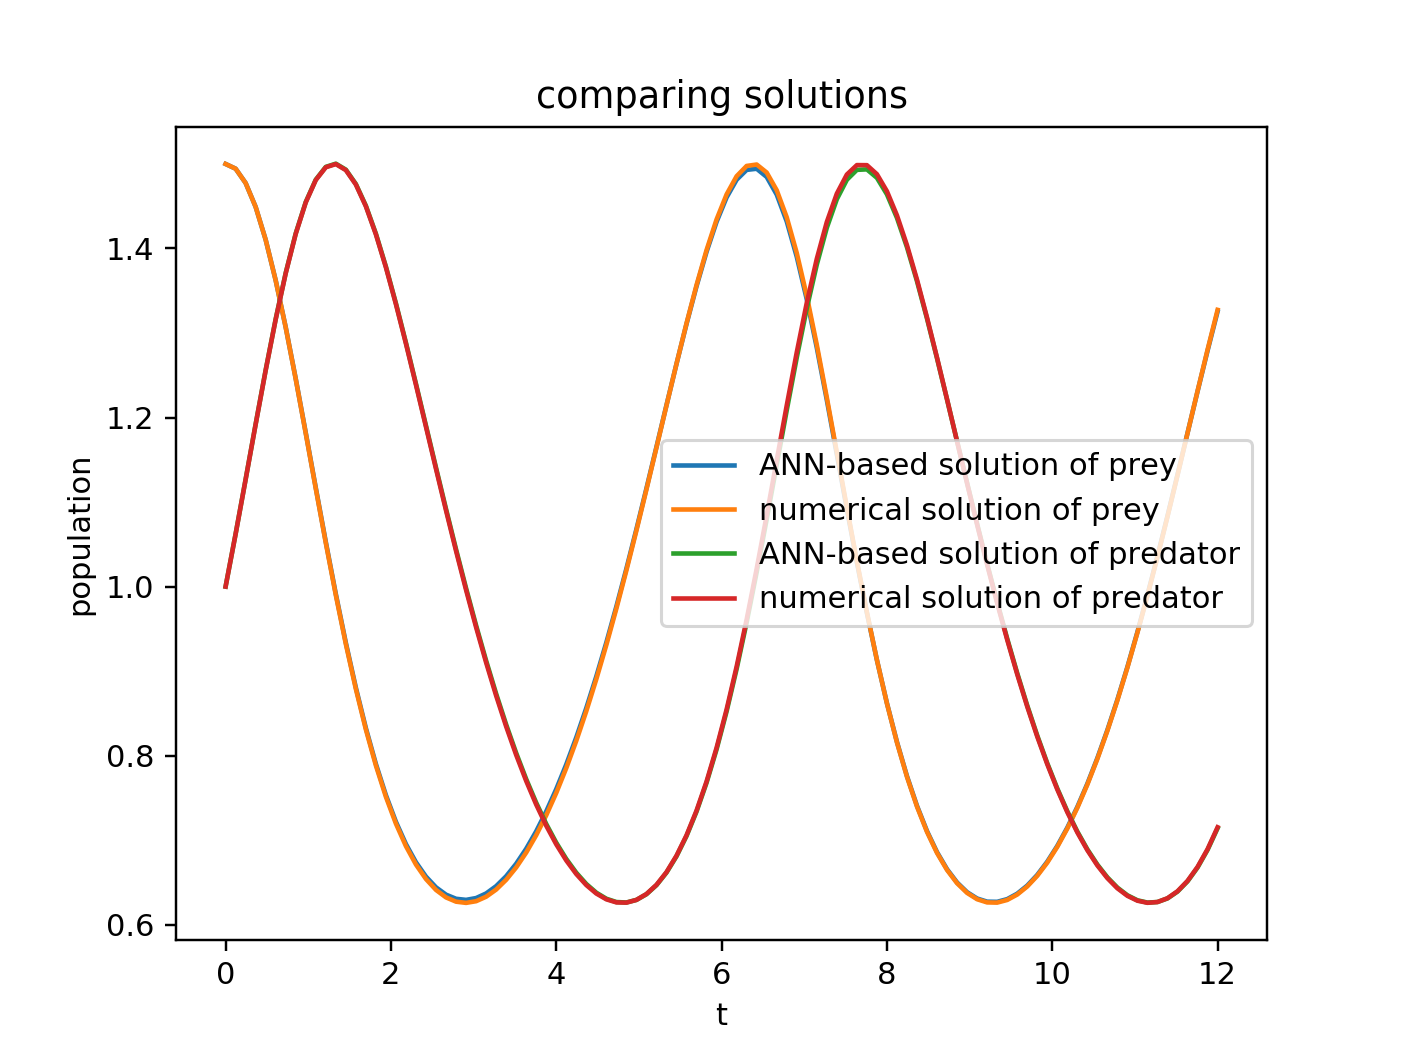

In [17]:
ts = np.linspace(0, 12, 100)

# ANN-based solution
prey_net, pred_net = solution_lv(ts, as_type='np')

# numerical solution
from scipy.integrate import odeint
def dPdt(P, t):
    return [P[0]*alpha - beta*P[0]*P[1], delta*P[0]*P[1] - gamma*P[1]]
P0 = [1.5, 1.0]
Ps = odeint(dPdt, P0, ts)
prey_num = Ps[:,0]
pred_num = Ps[:,1]

plt.figure()
plt.plot(ts, prey_net, label='ANN-based solution of prey')
plt.plot(ts, prey_num, label='numerical solution of prey')
plt.plot(ts, pred_net, label='ANN-based solution of predator')
plt.plot(ts, pred_num, label='numerical solution of predator')
plt.ylabel('population')
plt.xlabel('t')
plt.title('comparing solutions')
plt.legend()
plt.show()